# Capstone Project : Group 4 : Sub Part : Song Recommendation through content based filtering

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from google.colab import files
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format   

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

**READ SONG DATA**

In [4]:
song_data=pd.read_csv(r'/content/drive/My Drive/song_data_with_gender.csv')

**READ PLAY COUNT DATA**

In [5]:
count_data=pd.read_csv(r'/content/drive/My Drive/count_data.csv', index_col='Unnamed: 0') #Making unnamed: 0 an index column

**READ IMDb RATING DATA - "Externally Added"**

In [6]:
df_rating_data=pd.read_csv(r'/content/drive/My Drive/rating data.tsv', sep='\t')

**READ IMDb MOVIE TITLES DATA - "Externally Added"**

In [7]:
df_akas_data=pd.read_csv(r'/content/drive/My Drive/akas data.tsv', sep='\t')

**READ musixmatch mxm_779k_matches dataset "Externally Added"**

In [8]:
df_trackid_msd_artist=pd.read_csv(r'/content/drive/My Drive/mxm_779k_matches.txt', sep='<SEP>') # from http://millionsongdataset.com/musixmatch/#getting

**READ tagtraum msd_tagtraum_cd2c dataset "Externally Added"**

In [9]:
df_genre_data=pd.read_csv(r'/content/drive/My Drive/msd_tagtraum_cd2c.cls', sep='\t') #data from https://www.tagtraum.com/msd_genre_datasets.html

In [10]:
song_data.head()

,Unnamed: 0,song_id,title,release,artist_name,year,artist_gender
0,0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,male
1,1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,female
2,2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,female
3,3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,female
4,4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,male


In [11]:
count_data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [12]:
df_rating_data.head()

,tconst,averageRating,numVotes
0,tt0000001,5.70,1669
1,tt0000002,6.10,207
2,tt0000003,6.50,1392
3,tt0000004,6.20,123
4,tt0000005,6.20,2181


In [13]:
df_akas_data.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


**COMMENT:**
millionsongs dataset and IMDb have different indexes/keys and hence we need to analyse and see how to join based on common movie title. If there is no match, we need to find an alternate solution

**COMMENT:**
**Song data has some year values 0, which may not be useful in the analysis**



In [14]:
song_data.isnull().sum()

Unnamed: 0        0
song_id           0
title            15
release           5
artist_name       0
year              0
artist_gender     0
dtype: int64

**COMMENT**
**In Song data 15 titles and 5 releases are null values**

In [15]:
print('No of unique artists in the data=> ',song_data.artist_name.nunique())

No of unique artists in the data=>  72665


In [16]:
count_data.isnull().sum()

user_id       0
song_id       0
play_count    0
dtype: int64

**COMMENT**
**Play Count data has no null values**

# Checking Duplicates in Song Data

In [17]:
song_data.duplicated().value_counts()

False    1000000
dtype: int64

**COMMENT**
**Song data has 498 duplicates**, we will have treat duplicates before grouping and analysing data

In [18]:
count_data.duplicated().any()

False

**COMMENTS**
**Count data has no duplicates**

In [19]:
# Checking for duplicated rows in song data
song_data[song_data.duplicated()] #Duplicates are 498 in count

,Unnamed: 0,song_id,title,release,artist_name,year,artist_gender


In [20]:
# Checking a sample data
song_data[song_data.song_id=='SOPFBUZ12AF729C896']

,Unnamed: 0,song_id,title,release,artist_name,year,artist_gender
7055,7055,SOPFBUZ12AF729C896,Spitting Games,Final Straw,Snow Patrol,2003,male
18309,18309,SOPFBUZ12AF729C896,Spitting Games,Final Straw,Snow Patrol,2003,male


# Treating Duplicates in Song Data

In [21]:
# DROPPING DUPLICATES in SONG DATA with inplace=True
song_data.drop(song_data[song_data.duplicated()].index, inplace=True)

In [22]:
# CHECKING DUPLICATES AGAIN TO CONFIRM
song_data.duplicated().any()

False

# Checking null values in song title and release column

In [23]:
nan_song_df=song_data[song_data.title.isnull() | song_data.release.isnull()]
nan_song_df

,Unnamed: 0,song_id,title,release,artist_name,year,artist_gender
64262,64262,SOVICLT12A58A7C4D0,NaN,Of Flies And Men,Milton,0,male
114672,114672,SOAGRAA12AB018D567,NaN,Puce de luxe,Sébastien Roch,0,female
138011,138011,SOOBGAQ12A6D4F6762,Solitude,NaN,Metro,0,male
197822,197822,SOGFJER12A6D4F675F,All The Beautiful People,NaN,Metro,0,male
223019,223019,SOAFJBH12A6D4F6765,Down The Aisles,NaN,Metro,0,male
229353,229353,SOOAFJX12AB018A028,NaN,Puce de luxe,Sébastien Roch,0,female
264639,264639,SOLDTFD12AB018AFE6,NaN,Puce de luxe,Sébastien Roch,0,female
458083,458083,SOAUTVB12AB018AFF0,NaN,Puce de luxe,Sébastien Roch,0,female
557125,557125,SOMPGYE12AB018AFE0,NaN,Puce de luxe,Sébastien Roch,0,female
578241,578241,SOVHAZH12AB018D5B3,NaN,Puce de luxe,Sébastien Roch,0,female


**Checking null values in song title and release has any impact on play count data**
**If there is no play count data available for the Null titles and releases then we can ignore them as they will not impact our analysis** 

In [24]:
count_data.song_id.isin(nan_song_df.song_id).value_counts() 

False    2000000
Name: song_id, dtype: int64

**COMMENT:**
value_counts provides a False output which means there is **NO IMPACT** null titles do not have play counts. Hence, **IGNORE THEM NULL TITLES and RELEASES**

# Grouping and Merging DataSets

In [25]:
sorted_play_counts_df=count_data.groupby(['song_id','play_count']).sum().sort_values(by='play_count',ascending=False)
sorted_play_counts_df.reset_index(inplace=True)
sorted_play_counts_df.set_index('song_id', inplace=True)# making song_id index of the df, this is required to merge with song_data df

sorted_play_counts_df # Sorted in descending order of play_count to see the top play counts first


,play_count,user_id
song_id,,
SOFCGSE12AF72A674F,2213,d13609d62db6df876d3cc388225478618bb7b912
SOUAGPQ12A8AE47B3A,920,50996bbabb6f7857bf0c8019435b5246a0e45cfd
SOKOSPK12A8C13C088,879,5ea608df0357ec4fda191cb9316fe8e6e65e3777
SOZQSVB12A8C13C271,796,bb85bb79612e5373ac714fcd4469cabeb5ed94e1
SOBONKR12A58A7A7E0,683,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3
...,...,...
SOPRQRO12AB018906E,1,25fc0200450bbf726c8511fabe31ecfdb81732eb3fd3ac...
SOPROPB12A8C1385BD,1,732f88be38fae217f8ab7e24c20dd072436e3e40b12c78...
SOPROEW12A6D4FD0F7,1,4691b4c353503da2c108e372ff056a9ac847c4d1fb51c7...


In [26]:
songs_play_count_df=pd.merge(sorted_play_counts_df,song_data,on='song_id')

In [27]:
songs_play_count_df

,song_id,play_count,user_id,Unnamed: 0,title,release,artist_name,year,artist_gender
0,SOFCGSE12AF72A674F,2213,d13609d62db6df876d3cc388225478618bb7b912,567847,Starshine,Gorillaz,Gorillaz,2000,male
1,SOFCGSE12AF72A674F,26,a2f4a835133971255b6153bcd3472f2d9c414c1f,567847,Starshine,Gorillaz,Gorillaz,2000,male
2,SOFCGSE12AF72A674F,9,5843a275e43c5de3b77b6c5f0e9d521fadef2560,567847,Starshine,Gorillaz,Gorillaz,2000,male
3,SOFCGSE12AF72A674F,7,d45dadf7dd306b2f17afa48555c8d10cc2be219ed5a8ef...,567847,Starshine,Gorillaz,Gorillaz,2000,male
4,SOFCGSE12AF72A674F,6,d029b50513fe385d6b40b237da1ec0bf8745df6fee4feb...,567847,Starshine,Gorillaz,Gorillaz,2000,male
...,...,...,...,...,...,...,...,...,...
144347,SOSVQPX12A8C14078C,1,7da61f8ef076d56881f244daf7fc92e1f7872d563d7d0b...,561982,Pree-Sisters Swallowing a Donkey's Eye,On Avery Island,Neutral Milk Hotel,1996,male
144348,SOSLEFC12A6D4FC740,2,3d70fa5a6c04cf7fdfc43e73cee80fff24e8bed15cb3fc...,908288,Slan Le Maige,Heroes,Reel Feelings,0,male
144349,SOSLEFC12A6D4FC740,1,5a905f000fc1ff3df7ca807d57edb608863db05d8b0578...,908288,Slan Le Maige,Heroes,Reel Feelings,0,male
144350,SOXDPFW12A81C2319B,2,62c39ebced70b7a604682b8311215af24bf72ede0e5696...,641362,Ribbons,Ringer,Four Tet,2008,male


**COMMENT**
**songs_play_count_df has total rows of 142490 rows afer pd merge**

In [28]:
songs_play_count_df.isnull().any() # reconfirming presence of any null values.

song_id          False
play_count       False
user_id          False
Unnamed: 0       False
title            False
release          False
artist_name      False
year             False
artist_gender    False
dtype: bool

**There are no null values**

In [29]:
songs_play_count_df[songs_play_count_df['song_id']=='SOBONKR12A58A7A7E0']

,song_id,play_count,user_id,Unnamed: 0,title,release,artist_name,year,artist_gender
89,SOBONKR12A58A7A7E0,683,c012ec364329bb08cbe3e62fe76db31f8c5d8ec3,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
90,SOBONKR12A58A7A7E0,446,66ff466e107e9bcd7c6f2c59501ed0d7844c26c0,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
91,SOBONKR12A58A7A7E0,359,9c82c3083bc78157017cb31de4105e06d3f153f5,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
92,SOBONKR12A58A7A7E0,271,6a944bfe30ae8d6b873139e8305ae131f1607d5f,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
93,SOBONKR12A58A7A7E0,225,a0b5dcfe540fc177349d6f6063099bab8cd16da9,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
...,...,...,...,...,...,...,...,...,...
199,SOBONKR12A58A7A7E0,5,3f9ed694a79835c921ef6d94acd28f876c1d901e8bc273...,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
200,SOBONKR12A58A7A7E0,4,179b2286bb4eea7193bcfa0c36fcfa4eade2b34d766103...,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
201,SOBONKR12A58A7A7E0,3,be0a4b64e9689c46e94b5a9a9c7910ee61aeb16ffd585a...,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male
202,SOBONKR12A58A7A7E0,2,e006b1a48f466bf59feefed32bec6494495a44362b6c2f...,448841,You're The One,If There Was A Way,Dwight Yoakam,1990,male


**COMMENT:**
specific song_id = **SOFCGSE12AF72A674F** show that a user_id = **d13609d62db6df876d3cc388225478618bb7b912** has played it 2213 times, must be a crazy listner as the next best is only 26

In [30]:
# Making a dataframe where we have summation of times song is played in general and played by distincet users i.e count_play_count.(Number of times we have play_count for the users)
sum_play_count = songs_play_count_df.groupby('song_id').sum()['play_count']
count_play_count = songs_play_count_df.groupby('song_id').count()['play_count']
final_play_count=pd.DataFrame({'sum_play_count':sum_play_count,'count_play_count':count_play_count})

# Merge IMDb with Song Data

In [31]:
imdb_merge=pd.merge(df_akas_data,df_rating_data,left_on='titleId',right_on='tconst')

**COMMENT:**
IMDb song titles and IMDb ratings data merged

In [32]:
imdb_merge=imdb_merge[imdb_merge.ordering==1] #filtering further to remove duplicate titles

In [33]:
imdb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832707 entries, 0 to 3048144
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   titleId          832707 non-null  object 
 1   ordering         832707 non-null  int64  
 2   title            832707 non-null  object 
 3   region           832694 non-null  object 
 4   language         832707 non-null  object 
 5   types            832707 non-null  object 
 6   attributes       832707 non-null  object 
 7   isOriginalTitle  832707 non-null  object 
 8   tconst           832707 non-null  object 
 9   averageRating    832707 non-null  float64
 10  numVotes         832707 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 76.2+ MB


In [34]:
imdb_merge[imdb_merge.title=='Silent Night'] #Silent Night, Carmencita, Tomorrow Is Ours

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle,tconst,averageRating,numVotes
848977,tt0138427,1,Silent Night,DE,\N,\N,\N,0,tt0138427,7.10,149
1335463,tt0457474,1,Silent Night,US,\N,\N,\N,0,tt0457474,7.40,31
1388489,tt0511712,1,Silent Night,US,\N,\N,\N,0,tt0511712,8.60,14
1539708,tt0824401,1,Silent Night,XWW,en,\N,\N,0,tt0824401,5.60,12
1596299,tt0915979,1,Silent Night,GB,\N,\N,\N,0,tt0915979,9.60,7
1763592,tt1131980,1,Silent Night,AU,\N,\N,\N,0,tt1131980,8.40,27
1862463,tt1256286,1,Silent Night,US,\N,\N,\N,0,tt1256286,7.90,612
2195436,tt2098189,1,Silent Night,CA,\N,\N,\N,0,tt2098189,8.00,381
2233784,tt2234417,1,Silent Night,AU,\N,\N,\N,0,tt2234417,7.80,6
2239939,tt2254133,1,Silent Night,\N,\N,original,\N,1,tt2254133,6.80,5


In [35]:
song_imdb_merge=pd.merge(songs_play_count_df,imdb_merge,left_on='title',right_on='title') #Song data and IMDb rating data merged

In [36]:
song_imdb_merge.set_index('song_id',inplace=True) #Song data and IMDb rating data merged

**COMMENT:**
ABOVE DATA song_imdb_merge is of different regions and hence to get universal rating we can do an average of all regions and sum of numVotes

In [37]:
song_imdb_merge[song_imdb_merge['numVotes']>20]

,play_count,user_id,Unnamed: 0,title,release,artist_name,year,artist_gender,titleId,ordering,region,language,types,attributes,isOriginalTitle,tconst,averageRating,numVotes
song_id,,,,,,,,,,,,,,,,,,
SOZPMJT12AAF3B40D1,585,f1bdbb9fb7399b402a09fa124210dedf78e76034,577438,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009,female,tt0074041,1,US,\N,\N,\N,0,tt0074041,7.20,176
SOZPMJT12AAF3B40D1,585,f1bdbb9fb7399b402a09fa124210dedf78e76034,577438,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009,female,tt0117420,1,AU,\N,imdbDisplay,\N,0,tt0117420,5.60,24134
SOZPMJT12AAF3B40D1,585,f1bdbb9fb7399b402a09fa124210dedf78e76034,577438,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009,female,tt0316462,1,GB,\N,\N,\N,0,tt0316462,7.80,71
SOZPMJT12AAF3B40D1,585,f1bdbb9fb7399b402a09fa124210dedf78e76034,577438,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009,female,tt0529800,1,US,\N,\N,\N,0,tt0529800,7.50,72
SOZPMJT12AAF3B40D1,585,f1bdbb9fb7399b402a09fa124210dedf78e76034,577438,The Quest,A Taste Of Extreme Divinity,HYPOCRISY,2009,female,tt0553467,1,US,\N,\N,\N,0,tt0553467,7.20,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SOLYVPG12AB0185318,3,4be8732ad47ad1302dc16f8c30dbb14c138bfb366564c4...,977523,Sympathy,One Beat,Sleater-kinney,2002,female,tt1017461,1,\N,\N,original,\N,1,tt1017461,5.00,360
SOLYVPG12AB0185318,2,ee03697dfdf668a9cd19a44a6f257b9d6a1dc60a3b8479...,977523,Sympathy,One Beat,Sleater-kinney,2002,female,tt1017461,1,\N,\N,original,\N,1,tt1017461,5.00,360
SOLYVPG12AB0185318,1,baf47ed8da24d607e50d8684cde78b923538640fe3937c...,977523,Sympathy,One Beat,Sleater-kinney,2002,female,tt1017461,1,\N,\N,original,\N,1,tt1017461,5.00,360


In [38]:
df_trackid_msd_artist

,tid,artist name,title,mxm tid,artist_name,title.1
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos Querés,9239868,Yerba Brava,Si vos queres
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741,Franz Berwald,"Symphony No. 1 in G minor ""Sinfonie Sérieuse"":..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,Kris Kross,2 Da Beat Ch'yall
...,...,...,...,...,...,...
779051,TRYYYZM128F428E804,SKYCLAD,Inequality Street,788003,Skyclad,Inequality Street
779052,TRYYYON128F932585A,Loose Shus,Taurus (Keenhouse Remix),8564800,Loose Shus,Red Sonja
779053,TRYYYUS12903CD2DF0,Kiko Navarro,O Samba Da Vida,8472838,Kiko Navarro,A Samba Da Vida
779054,TRYYYMG128F4260ECA,Gabriel Le Mar,Novemba,1997445,Gabriel Le Mar,140 Degrees


**COMMENT:**
df_trackid_msd_artist has 779K rowswith trackID and artist, title mapping

In [39]:
df_genre_data

,track_id,genre
0,TRAAAAK128F9318786,Rock
1,TRAAAAW128F429D538,Rap
2,TRAAADJ128F4287B47,Rock
3,TRAAADZ128F9348C2E,Latin
4,TRAAAED128E0783FAB,Jazz
...,...,...
191396,TRZZZMY128F426D7A2,Reggae
191397,TRZZZRJ128F42819AF,Rock
191398,TRZZZUK128F92E3C60,Folk
191399,TRZZZZD128F4236844,Rock


**COMMENT:**
df_genre_data has 191K rows with track_ID and genre data which can be mapped with df_trackid_msd_artist to get genre mapping to MSD

In [40]:
df_genre_data.track_id.isin(df_trackid_msd_artist.tid).value_counts()


True     183891
False      7510
Name: track_id, dtype: int64

**COMMENT:**
There are only 183K rows available with genre data rest of genre will be empty

In [41]:
genre_final=pd.merge(df_trackid_msd_artist,df_genre_data,left_on='tid', right_on='track_id') # merge df_trackid_msd_artist and df_genre_data
genre_final.drop(columns=['mxm tid','track_id','artist name','title.1'],inplace=True)
genre_final

,tid,title,artist_name,genre
0,TRMMMXJ12903CBF111,El hijo del pueblo,Jorge Negrete,Latin
1,TRMMMXI128F4285A3F,N Gana,Waldemar Bastos,World
2,TRMMMKI128F931D80D,006,Lena Philipsson,Pop
3,TRMMMTK128F424EF7C,Rock-N-Rule,Emery,Rock
4,TRMMMRZ128F4265EB4,I'm Ready,Aerosmith,Rock
...,...,...,...,...
183886,TRYYYOU128F426B209,Interrotte Speranze,Coronatus,Metal
183887,TRYYYWX128F92E11D1,Wouldn't Get Far,The Game,Rap
183888,TRYYYHG128F9343EFB,Chill,Jazz Addixx,Rap
183889,TRYYYYS12903D0605A,Way Down,Taylor Hawkins & The Coattail Riders,Rock


# SONG DATA WITH GENRE

In [91]:
song_data_with_genre=pd.merge(genre_final,song_data,on=['title','artist_name'])
song_data_with_genre # SONG DATAFRAME WITH GENRE 185K ROWS

,tid,title,artist_name,genre,Unnamed: 0,song_id,release,year,artist_gender
0,TRMMMXJ12903CBF111,El hijo del pueblo,Jorge Negrete,Latin,11,SOLJTLX12AB01890ED,32 Grandes Éxitos CD 2,1997,female
1,TRMMMXI128F4285A3F,N Gana,Waldemar Bastos,World,14,SOGPCJI12A8C13CCA0,Afropea 3 - Telling Stories To The Sea,0,male
2,TRMMMKI128F931D80D,006,Lena Philipsson,Pop,15,SOSDCFG12AB0184647,Lena 20 År,1998,male
3,TRMMMTK128F424EF7C,Rock-N-Rule,Emery,Rock,18,SOIMMJJ12AF72AD643,I'm Only A Man (Bonus Track Version),2007,female
4,TRMMMRZ128F4265EB4,I'm Ready,Aerosmith,Rock,26,SOEEHEY12CF5F88FB4,Honkin' On Bobo,2004,female
...,...,...,...,...,...,...,...,...,...
185179,TRYYYOU128F426B209,Interrotte Speranze,Coronatus,Metal,999984,SOIQNVK12A8C13B061,Lux Noctis,2007,male
185180,TRYYYWX128F92E11D1,Wouldn't Get Far,The Game,Rap,363768,SOQDFGV12AB0183F25,R&B Collaborations 2007,0,female
185181,TRYYYWX128F92E11D1,Wouldn't Get Far,The Game,Rap,999988,SOYKHSL12AF72A35AC,Wouldn't Get Far,0,female
185182,TRYYYHG128F9343EFB,Chill,Jazz Addixx,Rap,999989,SOIDAMG12AB0182B3A,Oxygen Refreshed (Instrumentals),0,female


In [92]:
song_data_with_genre[song_data_with_genre.title=='Intro'] #CHECKING SPECIFICALLY ONE TITLE TO CHECK DUPLICATES. FIND NO ISSUES

,tid,title,artist_name,genre,Unnamed: 0,song_id,release,year,artist_gender
428,TRMWDJV128F42A3B15,Intro,Kool Savas & Azad,Rap,2721,SOGGXNU12A8C13E437,ONE,2005,male
1399,TRMRPKX128F932574E,Intro,Guts,Electronic,8224,SORTVZZ12AB018100F,Le Bienheureux,2007,male
1530,TRMRYPM12903CE17E0,Intro,Sabbat,Metal,8880,SOUDXIE12AB0188DC3,History Of A Time To Come,1988,male
2388,TRMQKJI128E0789035,Intro,Gorillaz,Rock,13298,SOUHXII12A67021873,Demon Days,2005,male
5928,TRMOFHL128F93233F7,Intro,Red,Rock,33272,SONIQSQ12AB01846A6,Too Hot,0,male
...,...,...,...,...,...,...,...,...,...
179596,TRKYKHX128E07861AA,Intro,Jay-Z,Rap,961567,SOLVAOU12A6702037D,The Dynasty,2000,female
180227,TRYGSMN128F14792E9,Intro,Ruoska,Metal,965865,SOTPEEC12A6D4F7330,Amortem,2006,female
180813,TRYRQYT12903CF2550,Intro,Diecast,Metal,969726,SOWLSER12A6D4FAC87,Day Of Reckoning,2001,male
184057,TRYVVNT128F42AE8C3,Intro,Chris Brown,RnB,992323,SOUZWGN12A58A7F591,Chris Brown,0,male


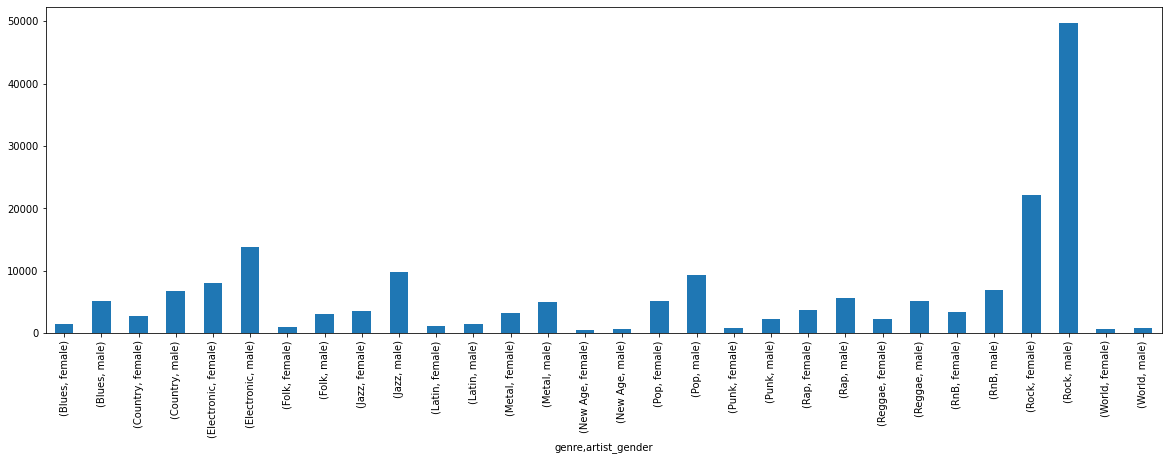

In [93]:
song_data_with_genre.groupby(['genre','artist_gender'])['song_id'].agg('count').plot(kind='bar')
#Gender on artist name is actually a QUESTION MARK as the data set does not contain proper names in artist_names, we find band names too in artist names.

**COMMENT:**


> There are considerable no of ROCK genre artists in both gender.


> Least in both gender in New Age genre


> We can do genre and gender'wise recommendation using this data







# Content Based Filtering

In content based recommendation system, below features are interesting to recommend a song

- Artist Name
- Play Count
- Gender
- Release
- Title
- Reviews

Text data generally is very noisy i.e. present pronunciation, stopwords, non-ascii characters makes it very noisy. So we will first need to pre-process the text. And then we will generate features from the text to compute similarities between the texts/reviews.


In [182]:
song_data_with_genre.shape

(185184, 9)

In [183]:
count_data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


In [184]:
count_data.shape

(2000000, 3)

In [185]:
song_play_count=songs_play_count_df.drop(['user_id','Unnamed: 0','title','release','artist_name','year','artist_gender',],axis=1)

In [188]:
songs_content_final = pd.merge(song_play_count, song_data_with_genre, on='song_id',how='inner')

In [189]:
songs_content_final.shape

(75609, 10)

In [ ]:
songs_content_final.s

In [98]:
songs_content_final['text'] = songs_content_final['title'] + ' ' + songs_content_final['artist_name'] + ' ' + songs_content_final['genre'] + ' ' + songs_content_final['release']
songs_content_final=songs_content_final[:1000]

In [103]:
songs_content_final.shape

(65, 5)

In [102]:
songs_content_final = songs_content_final[['tid', 'song_id', 'artist_name', 'title', 'text','play_count']]
songs_content_final = songs_content_final.drop_duplicates(subset=['title'])
songs_content_final = songs_content_final.set_index('title')
songs_content_final.head()

KeyError: ignored

In [49]:
song_data_with_genre['text'][0]

'El hijo del pueblo Jorge Negrete Latin 32 Grandes Éxitos  CD 2'

In [50]:
song_data_with_genre.shape

(890, 4)

In [51]:
indices = pd.Series(song_data_with_genre.index)
indices[:5]

0    El hijo del pueblo
1                N Gana
2                   006
3           Rock-N-Rule
4             I'm Ready
Name: title, dtype: object

**COMMENT:**
**Using natural language processing to handle the data in text

In [52]:
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [53]:
def tokenize(text):
    text = re.sub(r"[^a-zA-Z]"," ",text.lower())
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in stopwords.words("english")]
    text_lems = [WordNetLemmatizer().lemmatize(lem).strip() for lem in words]

    return text_lems

**COMMENT:**
Feature extraction - here we will be using tfidf as feature extraction technique from texts

In [54]:
tfidf = TfidfVectorizer(tokenizer=tokenize)
songs_tfidf = tfidf.fit_transform(song_data_with_genre['text'].values).toarray()

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
similar_songs = cosine_similarity(songs_tfidf, songs_tfidf)
similar_songs

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.07679538],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.07679538, 0.        ,
        1.        ]])

In [57]:
# function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):
    
    recommended_songs = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similar_songs[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    # populating the list with the titles of the best 10 matching songs
    for i in top_10_indexes:
        recommended_songs.append(list(song_data_with_genre.index)[i])
        
    return recommended_songs

In [58]:
recommendations('Rock-N-Rule', similar_songs)

[284, 250, 860, 604, 634, 156, 173, 771, 791, 830]


['Just A Man (Ellen Allien Version)',
 'So Hott (Explicit Album Version)',
 'Working Man (Rio Live Album Version)',
 'Outbroken (That Track)',
 'Straight Outta Now Rule',
 "Tu n'es pas là",
 'Wipe Out (LP Version)',
 'Who?',
 'The Man In The Bed',
 'Radioshadow']